In [1]:
# Enable auto reloading of notebook
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torchvision.models as models
from facenet_pytorch import MTCNN, InceptionResnetV1
from utils import *
from dog_breed_classifier import *
from networks import *
from dog_app import *

In [3]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))

Using cuda:0


In [4]:
# Load dog dataset
train_files, _, dog_targets_map = load_dog_dataset("data/dogImages/train")
valid_files, _, _ = load_dog_dataset("data/dogImages/valid")
test_files, _, _ = load_dog_dataset("data/dogImages/test")

# Load list of dog names
dog_names = dog_targets_map.keys()

# Print statistics about the dataset
print("There are %d total dog categories." % len(dog_names))
print(
    "There are %s total dog images.\n"
    % len(np.hstack([train_files, valid_files, test_files]))
)
print("There are %d training dog images." % len(train_files))
print("There are %d validation dog images." % len(valid_files))
print("There are %d test dog images." % len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [5]:
# Load human dataset
human_files = load_human_dataset("data/lfw")
random.shuffle(human_files)

# Print statistics about the dataset
print("There are %d total human images." % len(human_files))

There are 13233 total human images.


Number of detected faces:  1


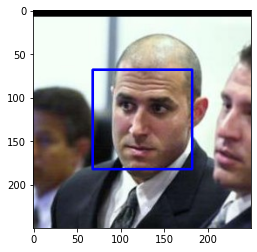

In [6]:
# Haarcascade
face_cascade = cv2.CascadeClassifier(
    "pretrained/haarcascades/haarcascade_frontalface_alt.xml"
)
print(
    "Number of detected faces: ",
    get_num_faces_haarcascade(str(human_files[0]), face_cascade),
)
visualize_faces_haarcascade(str(human_files[0]), face_cascade)

Number of detected faces:  1


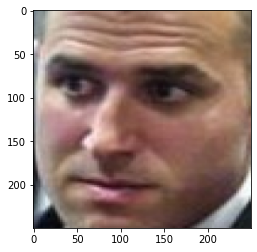

In [7]:
# PyTorch
mtcnn = MTCNN(image_size=250, keep_all=True, device=device)
print("Number of detected faces: ", get_num_faces_mtcnn(str(human_files[0]), mtcnn))
visualize_faces_mtcnn(str(human_files[0]), mtcnn)

In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


def assess_human_detector(human_files, dog_files, get_num_faces):
    num_true_positive = 0
    y_true = [0] * len(human_files) + [1] * len(dog_files)
    y_pred = []
    for x in human_files:
        next_pred = get_num_faces(x) > 0
        y_pred.append(0) if next_pred else y_pred.append(1)
        num_true_positive += 1 if next_pred else 0

    num_false_positive = 0
    for x in dog_files:
        next_pred = get_num_faces(x) > 0
        y_pred.append(0) if next_pred else y_pred.append(1)
        num_false_positive += 1 if next_pred else 0

    print(
        "Human faces correctly detected: {}/{}".format(
            num_true_positive, len(human_files)
        )
    )
    print(
        "Dog faces wrongly detected as human: {}/{}".format(
            num_false_positive, len(dog_files)
        )
    )
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=0
    )
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Fscore: {}".format(fscore))

In [9]:
print("Using Haar Cascade")
assess_human_detector(
    human_files_short,
    dog_files_short,
    lambda x: get_num_faces_haarcascade(str(x), face_cascade),
)

Using Haar Cascade
Human faces correctly detected: 97/100
Dog faces wrongly detected as human: 19/100
Precision: 0.8362068965517241
Recall: 0.97
Fscore: 0.8981481481481481


In [10]:
print("Using MTCNN")
assess_human_detector(
    human_files_short, dog_files_short, lambda x: get_num_faces_mtcnn(str(x), mtcnn)
)

Using MTCNN
Human faces correctly detected: 98/100
Dog faces wrongly detected as human: 27/100
Precision: 0.784
Recall: 0.98
Fscore: 0.8711111111111111


In [11]:
def assess_dog_detector(human_files, dog_files, detector, device):
    num_true_positive = 0
    y_true = [1] * len(dog_files) + [0] * len(human_files)
    y_pred = []
    for x in dog_files:
        next_pred = detect_dog_imagenet(str(x), detector, device)
        y_pred.append(1) if next_pred else y_pred.append(0)
        num_true_positive += 1 if next_pred else 0

    num_false_positive = 0
    for x in human_files:
        next_pred = detect_dog_imagenet(str(x), detector, device)
        y_pred.append(1) if next_pred else y_pred.append(0)
        num_false_positive += 1 if next_pred else 0

    print("Dogs correctly detected: {}/{}".format(num_true_positive, len(dog_files)))
    print(
        "Humans wrongly classified as dog: {}/{}".format(
            num_false_positive, len(human_files)
        )
    )
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1
    )
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Fscore: {}".format(fscore))

In [12]:
print("Using Resnet50")
resnet50 = models.resnet50(pretrained=True).to(device).eval()
assess_dog_detector(human_files_short, dog_files_short, resnet50, device)

Using Resnet50
Dogs correctly detected: 98/100
Humans wrongly classified as dog: 0/100
Precision: 1.0
Recall: 0.98
Fscore: 0.98989898989899


In [13]:
print("Using VGG16")
vgg16 = models.vgg16(pretrained=True).to(device).eval()
assess_dog_detector(human_files_short, dog_files_short, vgg16, device)

Using VGG16
Dogs correctly detected: 100/100
Humans wrongly classified as dog: 0/100
Precision: 1.0
Recall: 1.0
Fscore: 1.0


In [14]:
print("Using Inception V3")
inception_v3 = models.inception_v3(pretrained=True).to(device).eval()
assess_dog_detector(human_files_short, dog_files_short, inception_v3, device)

Using Inception V3
Dogs correctly detected: 100/100
Humans wrongly classified as dog: 0/100
Precision: 1.0
Recall: 1.0
Fscore: 1.0


In [15]:
simple_net = SimpleNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_net.parameters(), lr=3e-4)

In [16]:
print(simple_net)

SimpleNet(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=

In [17]:
dog_breed_classifier_pipeline = DogBreedClassifierPipeline(
    data_path="data/dogImages", model=simple_net, save_prefix="scratch"
)

In [18]:
# dog_breed_classifier_pipeline.train(num_epochs=10, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [19]:
dog_breed_classifier_pipeline.load(
    "pretrained/models/scratch_2021_10_09_230956979794_03339_best.pt"
)

Loading model from checkpoint pretrained/models/scratch_2021_10_09_230956979794_03339_best.pt


In [20]:
dog_breed_classifier_pipeline.evaluate(device)

Accuracy: 0.11363636363636363
Precision: 0.08756305370723919
Recall: 0.09879758921112304
Fscore: 0.07392314178341747


In [21]:
vgg16_dogbreed_net = VGGTransferLearningNet(vgg16).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_dogbreed_net.parameters(), lr=3e-4)

In [22]:
dog_breed_classifier_pipeline = DogBreedClassifierPipeline(
    data_path="data/dogImages", model=vgg16_dogbreed_net, save_prefix="vgg16_tf"
)

In [23]:
# dog_breed_classifier_pipeline.train(num_epochs=10, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [ ]:
dog_breed_classifier_pipeline.load(
    "pretrained/models/vgg16_tf_2021_10_10_102658274148_03900_best.pt"
)

In [24]:
dog_breed_classifier_pipeline.classify(str(train_files[0]), device)

(85, 'Irish_setter')

In [25]:
dog_breed_classifier_fn = lambda x: dog_breed_classifier_pipeline.classify(x, device)
dog_detector_fn = lambda x: detect_dog_imagenet(x, vgg16, device)
human_detector_fn = lambda x: get_num_faces_haarcascade(str(x), face_cascade)
dog_app = DogApp(dog_breed_classifier_fn, dog_detector_fn, human_detector_fn)

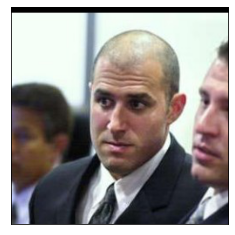

Not a dog but looks like a American_staffordshire_terrier


In [26]:
dog_app.run(str(human_files[0]))